<a href="https://colab.research.google.com/github/Mahshad-RM/MOR/blob/main/Assignments_overview_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
     from dlroms import*
except:
     !pip install --no-deps git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*
     import dlroms.fespaces as fe

# **Assignments overview - Part 1**

This notebook contains a brief overview of three assignments related to the first part of the course.

**NB**: if you are using Colab to run this notebook, make sure to upload the scripts $\textsf{dispenser.py}$, $\textsf{playground.py}$ and $\textsf{electron.py}$ to the notebook environment ("Folder" icon on your left, near the "Key" icon). If you are working locally, instead, make sure that those scripts are in the same folder of the notebook.

## **Convection-diffusion equation**: designing a chemical dispenser

In [ ]:
import numpy as np
import importlib
import dispenser
importlib.reload(dispenser)

from dispenser import FOMsolver, FOMsolverhom, Vh, Vb, compute_basis_functions # This line should work if FOMsolverhom is defined in dispenser.py

In [ ]:
# Compute basis functions
b1, b2, b3 = compute_basis_functions()
dispenser.b1 = b1  # Make b1, b2, b3 available in dispenser.py
dispenser.b2 = b2
dispenser.b3 = b3

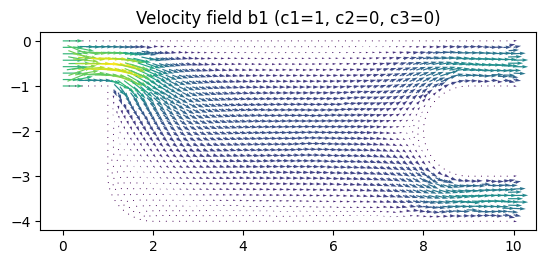

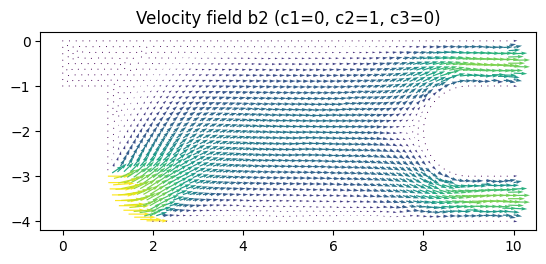

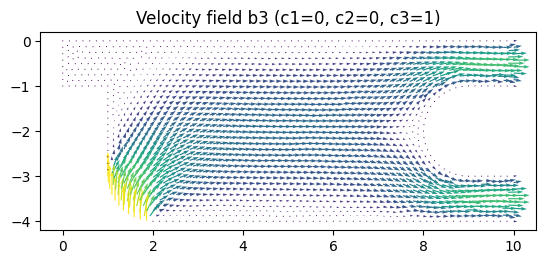

In [ ]:
import matplotlib.pyplot as plt
from fenics import plot

# Convert to FEniCS Function for plotting
bf1 = fe.asfunction(b1, Vb)
bf2 = fe.asfunction(b2, Vb)
bf3 = fe.asfunction(b3, Vb)

# Plot b1
plt.figure()
plot(bf1, title="Velocity field b1 (c1=1, c2=0, c3=0)")
plt.show()

# Plot b2
plt.figure()
plot(bf2, title="Velocity field b2 (c1=0, c2=1, c3=0)")
plt.show()

# Plot b3
plt.figure()
plot(bf3, title="Velocity field b3 (c1=0, c2=0, c3=1)")
plt.show()


In [ ]:
c0= np.array([40, 20, 30])
u = FOMsolver(*c0)
u.shape


(701, 1940)

In [ ]:
uhom, *_ =FOMsolverhom(*c0)
uhom.shape

(701, 1940)

In [ ]:
# Verify that u = uₕₒₘ + 1
error = np.max(np.abs(u - (uhom + 1)))
print(f"Maximum error between u and uₕₒₘ + 1: {error}")

Maximum error between u and uₕₒₘ + 1: 0.00716084910853515


In [ ]:
#fe.animate(u[::10], Vh)

In [ ]:
#fe.animate(u_hom[::10], Vh)

In [ ]:
from dispenser import bottomOutflow

print(bottomOutflow(u))

0.022940463063376885


In [ ]:
np.random.seed(0)

nsim = 20
cList = []
uhomList = []

for j in range(nsim):
  cj = 50 * np.random.rand(3)
  uhomj, u0j = FOMsolverhom(*cj)

  cList.append(cj)
  uhomList.append(uhomj)


In [ ]:
c = np.stack(cList)
uhom = np.stack(uhomList)

In [ ]:
c.shape

(20, 3)

In [ ]:
uhom.shape # snapshots matrix: Nh x Nsamples

(20, 701, 1940)

In [ ]:
ntrain = nsim // 2
Utrain = uhom[:ntrain].reshape(-1, Vh.dim()).T
Utrain.shape

(1940, 7010)

In [ ]:
from scipy.linalg import svd
X, s, Yt = svd(Utrain, full_matrices = False)

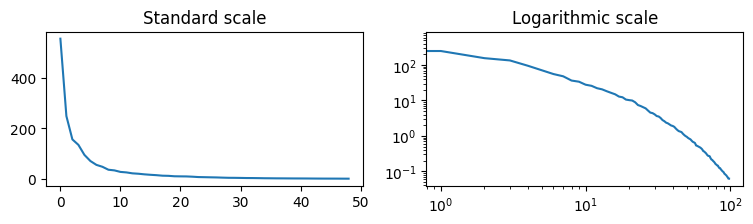

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (9, 2))
plt.subplot(1,2,1)
plt.plot(s[1:50])
plt.title("Standard scale")
plt.subplot(1,2,2)
plt.loglog(s[1:100])
plt.title("Logarithmic scale")
plt.show()

In [ ]:
n = 40
V = X[:, :n]

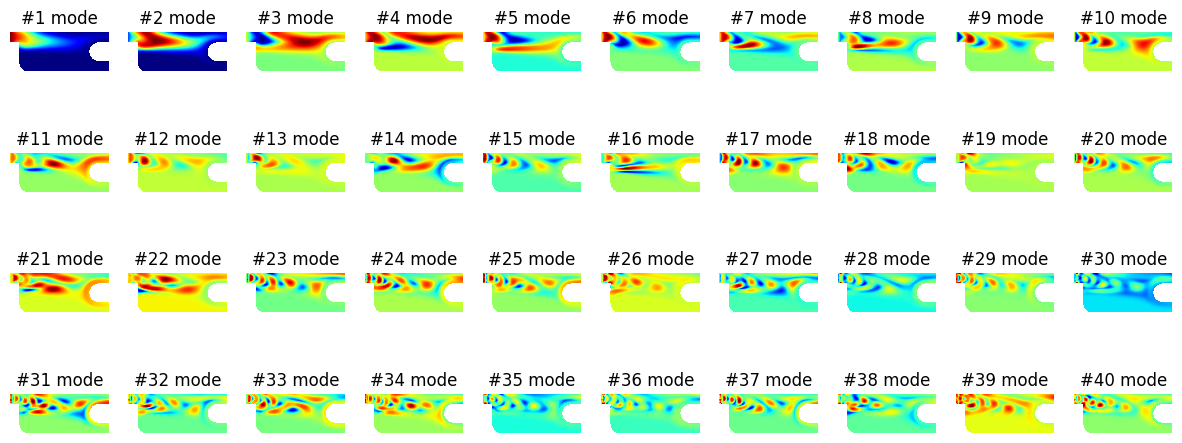

In [ ]:
plt.figure(figsize = (15, 6))
for k in range(n):
  plt.subplot(4, n//4, k+1)
  fe.plot(V[:, k], Vh)
  plt.title("#%d mode" % (k+1))
plt.show()

In [ ]:
from dlroms import num2p
Utest = uhom[ntrain:].reshape(-1, Vh.dim()).T
Uproj = V @ (V.T @ Utest)

errors = np.linalg.norm(Utest - Uproj, axis = 0) / np.linalg.norm(Utest, axis = 0)

ntest = uhom.shape[0] - ntrain
errors = errors.reshape(ntest, uhom.shape[1])

print("Average projection error: %s." % num2p(errors.max(axis = 1).mean()))

Average projection error: 1.56%.


In [ ]:
from dispenser import assemble_FOM_matrices

M, S, B1, B2, B3 = assemble_FOM_matrices()

Mrb  = V.T @ M  @ V
Srb  = V.T @ S  @ V
B1rb = V.T @ B1 @ V
B2rb = V.T @ B2 @ V
B3rb = V.T @ B3 @ V


In [ ]:
def RBstep(cn, dt, mu):
    c1, c2, c3 = mu
    Arb = Mrb + dt * Srb + dt * (c1 * B1rb + c2 * B2rb + c3 * B3rb)
    Frb = Mrb @ cn
    return np.linalg.solve(Arb, Frb)

In [ ]:
u0 = u0j
u0.shape

(1940,)

In [ ]:
def RBsolver(mu, dt=0.001, steps=700):
    c0 = V.T @ u0  # Project initial condition to reduced space
    c = [c0]

    for _ in range(steps):
        c.append(RBstep(c[-1], dt, mu))

    c = np.stack(c)
    u = c @ V.T
    u[0] = u0  # Set initial condition back in full space
    return u

In [ ]:
mu0 = np.array([40, 20, 30])
uFOM = FOMsolverhom(*mu0)
uRB = RBsolver(mu0)

-0.9315250404917896


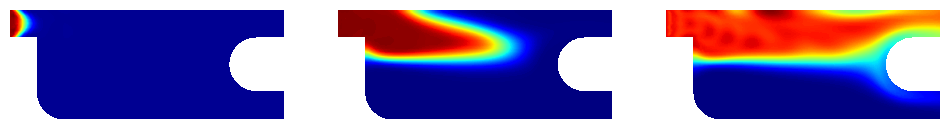

In [ ]:
# Assuming uFOM is a tuple whe

#fe.animate(uRB[::10], Vh)
fe.multiplot(uRB[[10, 200, 700]],  (1, 3),Vh)

j_rb = bottomOutflow(uRB)
print(j_rb)

-0.9769096209275409


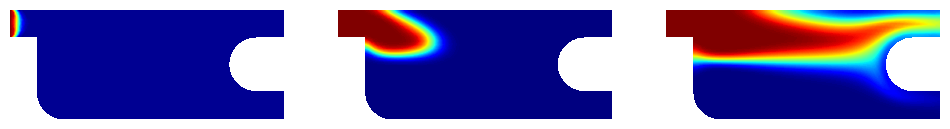

In [ ]:
# Assuming uFOM is a tuple where the first element contains the simulation data
#uFOM_data = uFOM[0]

#fe.animate(uFOM_data[::10], Vh)
# Assuming uFOM is a tuple where the first element contains the simulation data
uFOM_data = uFOM[0]

# Access specific time steps using slicing
fe.multiplot(uFOM_data[[10, 200, 700]],  (1, 3),Vh)
j_fom = bottomOutflow(uFOM_data)
print(j_fom)

In [ ]:
from time import time
from dispenser import bottomOutflow

errors = []
times_rb = []
times_fom = []
outflow_errors = []

test_nsim = 10
rel_errors_timewise = []

for j in range(test_nsim):
    mu = 50 * np.random.rand(3)

    # FOM
    t0 = time()
    u_fom, u0j = FOMsolverhom(*mu, steps=700, dt=5e-4)
    times_fom.append(time() - t0)

    # RB
    u0 = u0j  # shape (Nh,)
    t0 = time()
    u_rb = RBsolver(mu, dt=5e-4, steps=700)
    times_rb.append(time() - t0)

    # Pointwise relative error over time
    error = np.linalg.norm(u_fom - u_rb, axis=1) / np.linalg.norm(u_fom, axis=1)
    rel_errors_timewise.append(error)

    # Average relative error over time
    avg_rel_error = np.mean(error)
    errors.append(avg_rel_error)

    # Compare functionals
    j_fom = bottomOutflow(u_fom)
    j_rb = bottomOutflow(u_rb)
    outflow_err = abs(j_fom - j_rb) / abs(j_fom)
    outflow_errors.append(outflow_err)


In [ ]:
print(f"Mean relative error: {np.mean(errors):.4f}")
print(f"Mean RB time: {np.mean(times_rb):.3f} s, Mean FOM time: {np.mean(times_fom):.3f} s")
print(f"Speedup factor: {np.mean(times_fom) / np.mean(times_rb):.2f}x")


Mean relative error: 0.0038
Mean RB time: 0.047 s, Mean FOM time: 17.366 s
Speedup factor: 370.86x


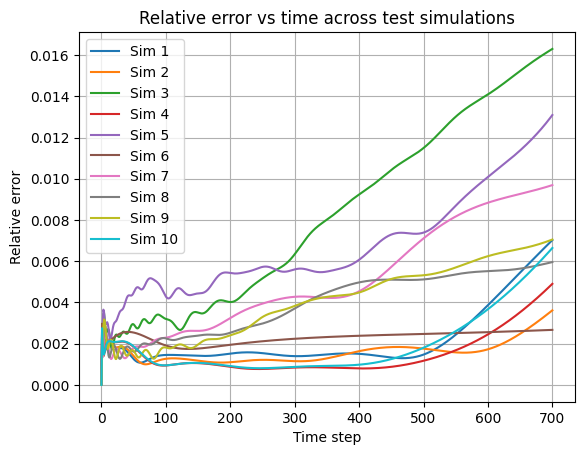

In [ ]:
import matplotlib.pyplot as plt

for j in range(test_nsim):
    plt.plot(rel_errors_timewise[j], label=f"Sim {j+1}")
plt.xlabel("Time step")
plt.ylabel("Relative error")
plt.title("Relative error vs time across test simulations")
plt.legend()
plt.grid(True)
plt.show()


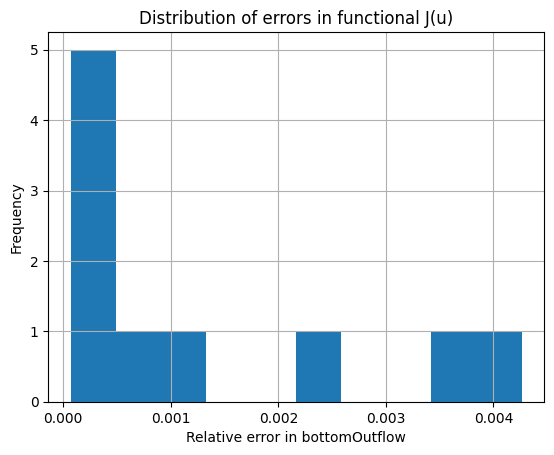

In [ ]:
plt.hist(outflow_errors, bins=10)
plt.xlabel("Relative error in bottomOutflow")
plt.ylabel("Frequency")
plt.title("Distribution of errors in functional J(u)")
plt.grid(True)
plt.show()


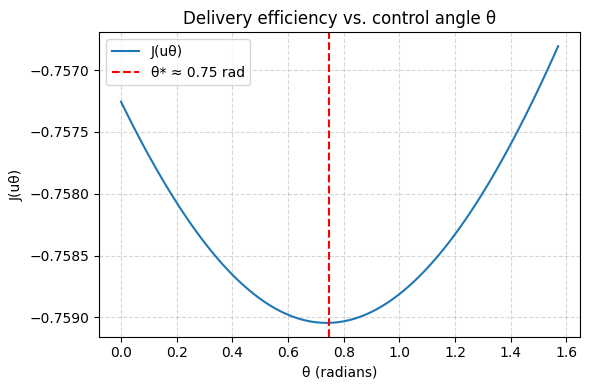

Optimal θ* ≈ 0.7457 radians ≈ 42.73 degrees
Minimum J(uθ) ≈ -0.759044


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dispenser import bottomOutflow

# Define parameters
c1 = 50
theta_vals = np.linspace(0, np.pi / 2, 100)
J_vals = []

# Loop over θ values
for theta in theta_vals:
    c2 = np.cos(theta)
    c3 = np.sin(theta)
    mu = [c1, c2, c3]

    u_theta = RBsolver(mu, dt=5e-4, steps=700)  # same dt and steps as FOM
    J_val = bottomOutflow(u_theta)
    J_vals.append(J_val)

# Find the optimal theta
theta_star_index = np.argmin(J_vals)
theta_star = theta_vals[theta_star_index]
J_min = J_vals[theta_star_index]

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(theta_vals, J_vals, label='J(uθ)')
plt.axvline(theta_star, color='r', linestyle='--', label=f'θ* ≈ {theta_star:.2f} rad')
plt.xlabel("θ (radians)")
plt.ylabel("J(uθ)")
plt.title("Delivery efficiency vs. control angle θ")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print(f"Optimal θ* ≈ {theta_star:.4f} radians ≈ {np.degrees(theta_star):.2f} degrees")
print(f"Minimum J(uθ) ≈ {J_min:.6f}")
